In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Set the style
# sns.set_style("whitegrid")
# sns.set_palette("husl")

# Some useful functions

In [49]:
def analyze_factor_levels(df):
    """Counts occurrence of each level across all columns in factorial experiment."""
    analysis = {col: df[col].value_counts() for col in df.columns}
    return analysis

# Read in the data

In [50]:
df_main = pd.read_csv('outputs/results_evostar2025_main.csv', index_col=0)
df_pso = pd.read_csv("outputs/results_pso_mut_123_2024_11_13.csv", index_col=0)

In [51]:
def rename_problems_solvers_size_cats(df):

    renames = {
        'HelloWorld': 'StringM',
        'SymbolicRegression': 'BFS',
        'GrammaticalEvolution': 'GE',
        'NeuralNetwork': 'NN'
    }

    for k in renames:
        df['problem'] = df['problem'].str.replace(k, renames[k])

    renames = {
        'particle_swarm_optimisation': 'PS',
        'random_search': 'RS',
        'genetic_algorithm': 'GA',
        'hill_climber': 'HC',
    }

    for k in renames:
        df['solver'] = df['solver'].str.replace(k, renames[k])

    renames = {
        'xlarge': 'X', # in reverse order, to avoid renaming 'xlarge' as 'xL'
        'large': 'L',
        'medium': 'M',
        'small': 'S',
    }

    for k in renames:
        df['size_cat'] = df['size_cat'].str.replace(k, renames[k])
    return df

df_main = rename_problems_solvers_size_cats(df_main)
df_pso = rename_problems_solvers_size_cats(df_pso)

# For main data, check its shape, size, and levels of each factor - it is a factorial experiment

In [52]:
df_main.shape

(13440, 14)

In [53]:
len(df_main) == 7 * 4 * 4 * 2 * 2 * 30 # 7 problems, 4 sizes, 4 solvers, 2 dist_types, 2 name_types, 30 reps

True

In [54]:
analyze_factor_levels(df_main[['problem', 'size_cat', 'solver', 'dist_type', 'name_type', 'rep']])

{'problem': problem
 OneMax     1920
 StringM    1920
 Sphere     1920
 TSP        1920
 BFS        1920
 GE         1920
 NN         1920
 Name: count, dtype: int64,
 'size_cat': size_cat
 S    3360
 M    3360
 L    3360
 X    3360
 Name: count, dtype: int64,
 'solver': solver
 RS    3360
 HC    3360
 GA    3360
 PS    3360
 Name: count, dtype: int64,
 'dist_type': dist_type
 coarse    6720
 fine      6720
 Name: count, dtype: int64,
 'name_type': name_type
 lin    6720
 str    6720
 Name: count, dtype: int64,
 'rep': rep
 0     448
 1     448
 28    448
 27    448
 26    448
 25    448
 24    448
 23    448
 22    448
 21    448
 20    448
 19    448
 18    448
 17    448
 16    448
 15    448
 14    448
 13    448
 12    448
 11    448
 10    448
 9     448
 8     448
 7     448
 6     448
 5     448
 4     448
 3     448
 2     448
 29    448
 Name: count, dtype: int64}

# For PSO mutation experiment (not used in the paper), check shape, size and levels

In [55]:
df_pso.shape

(5040, 14)

In [56]:
len(df_pso) == 7 * 3 * 1 * 2 * 2 * 3 * 20 # 7 problems, 3 sizes, 1 solvers, 2 dist_types, 2 name_types, 3 mutation values, 20 reps

True

In [57]:
analyze_factor_levels(df_pso[['problem', 'size_cat', 'solver', 'dist_type', 'name_type', 'rep']])

{'problem': problem
 OneMax     720
 StringM    720
 Sphere     720
 TSP        720
 BFS        720
 GE         720
 NN         720
 Name: count, dtype: int64,
 'size_cat': size_cat
 S    1680
 M    1680
 L    1680
 Name: count, dtype: int64,
 'solver': solver
 PS    5040
 Name: count, dtype: int64,
 'dist_type': dist_type
 coarse    2520
 fine      2520
 Name: count, dtype: int64,
 'name_type': name_type
 lin    2520
 str    2520
 Name: count, dtype: int64,
 'rep': rep
 0     252
 1     252
 18    252
 17    252
 16    252
 15    252
 14    252
 13    252
 12    252
 11    252
 10    252
 9     252
 8     252
 7     252
 6     252
 5     252
 4     252
 3     252
 2     252
 19    252
 Name: count, dtype: int64}

In [58]:
def create_problem_crosstab(problem_size_df, index): # by Claude. create a cross-tab with mean(+/- sd) for each problem instance

    # Create a multi-index column for (dist_type, name_type)
    problem_size_df['config'] = problem_size_df.apply(
        lambda row: f"{row['dist_type']}_{row['name_type']}", axis=1)
    
    # Create the cross-tabs for mean and std
    mean_tab = pd.pivot_table(problem_size_df, values='norm_fx', index=index, 
                            columns='config', aggfunc='mean')
    std_tab = pd.pivot_table(problem_size_df, values='norm_fx', index=index, 
                            columns='config', aggfunc='std')
    
    # Combine mean and std into a single table with formatted strings
    ctab = pd.DataFrame(index=mean_tab.index, columns=mean_tab.columns)
    for col in mean_tab.columns:
        for idx in mean_tab.index:
            mean_val = mean_tab.loc[idx, col]
            std_val = std_tab.loc[idx, col]
            ctab.loc[idx, col] = f"{mean_val:.2f} (±{std_val:.2f})"
    
    # Calculate row means and stds
    row_means = mean_tab.mean(axis=1)
    row_stds = mean_tab.std(axis=1)
    ctab['Mean'] = [f"{m:.2f} (±{s:.2f})" for m, s in zip(row_means, row_stds)]
    
    # Calculate column means and stds (including the Mean column)
    mean_with_summary = pd.concat([mean_tab, row_means.rename('Mean')], axis=1)
    std_with_summary = pd.concat([std_tab, row_stds.rename('Mean')], axis=1)
    
    # Create the Mean row with all columns (including Mean column)
    mean_row = [f"{m:.2f} (±{s:.2f})" for m, s in 
                zip(mean_with_summary.mean(), mean_with_summary.std())]
    
    ctab.loc['Mean'] = mean_row
    
    return ctab

# First group by problem and size, then create cross-tabs for each combination
grouped = df_main.groupby(['problem', 'size_cat'])

# Create and print cross-tabs for each problem and size
for (problem, size_cat), group in grouped:
    print(f"\n{problem} - Size: {size_cat}\n")
    ctab = create_problem_crosstab(group, 'solver')
    print(ctab)
    print("\n" + "="*50)  # Separator between problems

    ctab.to_latex(f'outputs/results_crosstab_main_{problem}_{size_cat}.tex')

with open('outputs/results_crosstab_tmp.txt', 'w') as f:
    for (problem, size), group in grouped:
        f.write(f"\n{problem} - Size: {size}\n")
        ctab = create_problem_crosstab(group, 'solver')
        f.write(ctab.to_string())
        f.write("\n\n" + "="*50 + "\n")

# First group by problem and size, then create cross-tabs for each combination
grouped = df_pso.groupby(['problem', 'size_cat'])

# Create and print cross-tabs for each problem and size
for (problem, size_cat), group in grouped:
    print(f"\n{problem} - Size: {size_cat}\n")
    ctab = create_problem_crosstab(group, 'mut')
    print(ctab)
    print("\n" + "="*50)  # Separator between problems

    ctab.to_latex(f'outputs/results_crosstab_pso_{problem}_{size_cat}.tex')

with open('outputs/results_crosstab_tmp_pso.txt', 'w') as f:
    for (problem, size), group in grouped:
        f.write(f"\n{problem} - Size: {size}\n")
        ctab = create_problem_crosstab(group, 'mut')
        f.write(ctab.to_string())
        f.write("\n\n" + "="*50 + "\n")


BFS - Size: L

config    coarse_lin    coarse_str      fine_lin      fine_str          Mean
solver                                                                      
GA      0.49 (±0.06)  0.60 (±0.09)  0.45 (±0.06)  0.53 (±0.06)  0.52 (±0.06)
HC      0.53 (±0.06)  0.65 (±0.06)  0.35 (±0.12)  0.36 (±0.13)  0.47 (±0.14)
PS      0.54 (±0.07)  0.65 (±0.07)  0.46 (±0.06)  0.50 (±0.07)  0.54 (±0.08)
RS      0.42 (±0.04)  0.42 (±0.04)  0.42 (±0.04)  0.42 (±0.04)  0.42 (±0.00)
Mean    0.50 (±0.06)  0.58 (±0.11)  0.42 (±0.05)  0.45 (±0.08)  0.49 (±0.05)


BFS - Size: M

config    coarse_lin    coarse_str      fine_lin      fine_str          Mean
solver                                                                      
GA      0.61 (±0.07)  0.67 (±0.06)  0.58 (±0.08)  0.61 (±0.08)  0.62 (±0.03)
HC      0.62 (±0.07)  0.65 (±0.09)  0.44 (±0.18)  0.46 (±0.20)  0.54 (±0.11)
PS      0.61 (±0.06)  0.67 (±0.07)  0.56 (±0.08)  0.60 (±0.07)  0.61 (±0.05)
RS      0.55 (±0.06)  0.55 (±0.06)  0.55 (±

In [59]:
# by Claude.
def plot_experiment_results(df, output_dir=None):
    # Get unique problems
    problems = df['problem'].unique()
    
    for problem in problems:
        # Create a copy of the filtered data
        problem_df = df[df['problem'] == problem].copy()
        
        # Create ordered categorical variables first
        #size_order = ['small', 'medium', 'large']
        #problem_df['size_cat'] = pd.Categorical(problem_df['size_cat'], categories=size_order, ordered=True)

        # Then create groups in desired order
        problem_df['group'] = (problem_df['size_cat']        + '_' + 
                               problem_df['mut'].astype(str) + '_' + 
                               problem_df['dist_type']       + '_' + 
                               problem_df['name_type']              )
                            
        # Create the ordered list of all possible combinations
        group_order = []
        for size in ['small', 'medium', 'large', 'xlarge']:
            for m in ['1', '2', '3']:
                for dist in ['coarse', 'fine']:
                    for name in ['lin', 'str']:            
                        group_order.append(f"{size}_{m}_{dist}_{name}")

        # Create figure with appropriate size
        plt.figure(figsize=(15, 8))
        
        # Create the strip plot for individual points
        sns.stripplot(data=problem_df, x='group', y='norm_fx', 
                     size=4, alpha=0.3, jitter=0.2, color='blue',
                     order=group_order)
        
        # Add mean points
        sns.pointplot(data=problem_df, x='group', y='norm_fx',
                     color='red', scale=0.7, markers='D',
                     order=group_order)
        
        # Customize the plot
        plt.title(f'Results for {problem}', pad=20, size=14)
        plt.xlabel('Configuration (size_mutation_distribution_naming)', size=12)
        plt.ylabel('Normalized Fitness', size=12)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        
        # Save the plot if output directory is provided
        if output_dir:
            plt.savefig(f'{output_dir}/{problem}_results.png', 
                       bbox_inches='tight')
        
        plt.close()

In [60]:
# Example usage:
# plot_experiment_results(df_main, output_dir='outputs/')

In [61]:
# Define the order for problems and solvers
problem_order = ['OneMax', 'StringM', 'Sphere', 'TSP', 
                'BFS', 'GE', 
                'NN']

solver_order = ['RS', 'HC', 'GA', 'PS']

size_order = 'SMLX'

group_order = [
    'lin - coarse',
    'str - coarse',
    'lin - fine',
    'str - fine'
]

In [62]:
def make_barplot(data, x, y, hue, hue_order, order, dodge, filename, legend_title='', loc='best', palette=None):
    # Create the plot
    plt.figure(figsize=(5, 3))
    sns.barplot(data=data,
                x=x,
                y=y,
                hue=hue,
                hue_order=solver_order,
                order=order,
                errorbar='sd',
                err_kws={"color": "0.0", "linewidth": 1.},
                capsize=0.5,
                palette=palette
                )  

    # Customize the plot
    # plt.title('Mean Performance by Problem and Solver', pad=20)
    plt.xlabel('')
    plt.ylabel('Mean Normalized Performance')
    plt.ylim((0.0, 1.05))

    # Rotate x-axis labels
    #plt.xticks(rotation=45, ha='right')

    # Add legend inside the plot
    plt.legend(title=legend_title, loc=loc)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.savefig(filename)


# Plots using stripplot + pointplot

In [63]:
def make_dotplot(data, x, y, hue, hue_order, order, dodge, filename, legend_title='', loc='best', palette=None):
    
    # Create the plot
    plt.figure(figsize=(5, 3))
    # First create stripplot
    g = sns.stripplot(data=data,
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        order=order,
        size=4,
        alpha=0.5,
        dodge=True,
        zorder=1,
        palette=palette
    )

    # Add pointplot with matching dodge
    sns.pointplot(data=data,
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        errorbar='sd',
        # capsize=0.2,
        ax=plt.gca(),
        markers='_',
        linestyle='none',
        dodge=dodge,  # This aligns with stripplot groups
        err_kws={"color": "0.0", "linewidth": 1.},
        palette='dark:black',
        zorder=2,
        legend=False,
        # errorbar=None
    )

    # Customize the plot
    # plt.title('Mean Performance by Problem and Solver', pad=20)
    plt.xlabel('')
    plt.ylabel('Mean Normalized Performance')
    plt.ylim((0.0, 1.05))

    # Rotate x-axis labels
    #plt.xticks(rotation=45, ha='right')

    # Add legend inside the plot
    leg = plt.legend(title=legend_title, loc=loc)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.savefig(filename)
    

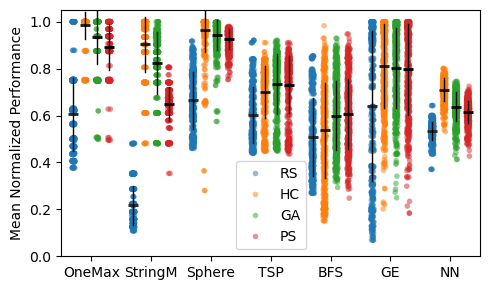

In [64]:
make_dotplot(df_main, 
             x='problem', y='norm_fx', hue='solver', hue_order=solver_order, order=problem_order, dodge=0.6, loc='lower center',
             filename='outputs/problem_v_solver_dotplot.pdf')

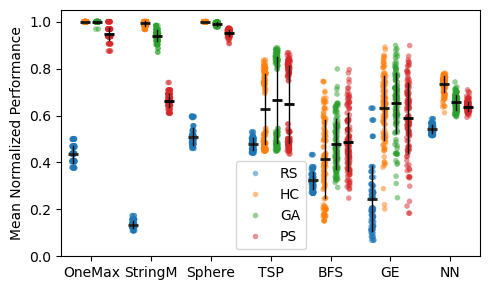

In [65]:
make_dotplot(df_main[df_main['size_cat'] == 'X'], 
             x='problem', y='norm_fx', hue='solver', hue_order=solver_order, order=problem_order, dodge=0.6, 
             filename='outputs/problem_v_solver_xlarge_dotplot.pdf')

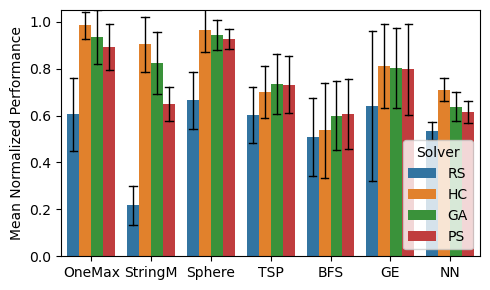

In [66]:
make_barplot(data=df_main, 
             x='problem', y='norm_fx', hue='solver', hue_order=solver_order, order=problem_order, dodge=0.6, legend_title="Solver",
             filename='outputs/problem_v_solver_barplot.pdf')

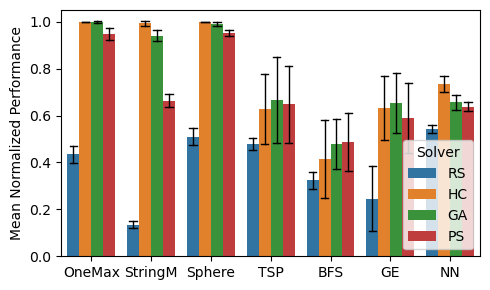

In [67]:
make_barplot(df_main[df_main['size_cat'] == 'X'], 
             x='problem', y='norm_fx', hue='solver', hue_order=solver_order, order=problem_order, dodge=0.6, legend_title="Solver",
             filename='outputs/problem_v_solver_xlarge_barplot.pdf')

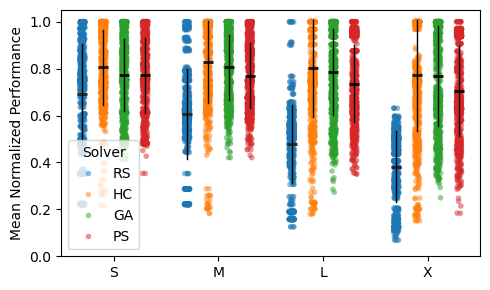

In [68]:
make_dotplot(df_main, 
             x='size_cat', y='norm_fx', hue='solver', hue_order=solver_order, order=size_order, dodge=0.6, legend_title="Solver",
             filename='outputs/size_v_solver_dotplot.pdf')

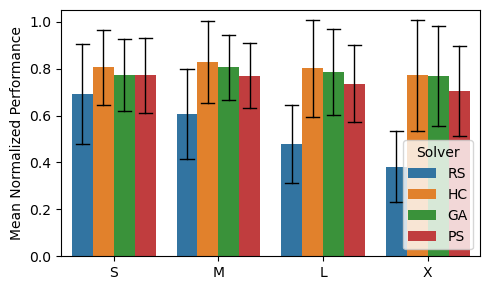

In [69]:
make_barplot(df_main, 
             x='size_cat', y='norm_fx', hue='solver', hue_order=solver_order, order=size_order, dodge=0.6, legend_title="Solver",
             filename='outputs/size_v_solver_barplot.pdf')

In [70]:
# Create a combined category for x-axis
df_main['name_dist'] = (df_main['name_type'] + ' - ' + 
                              df_main['dist_type'])
name_dist_order = group_order


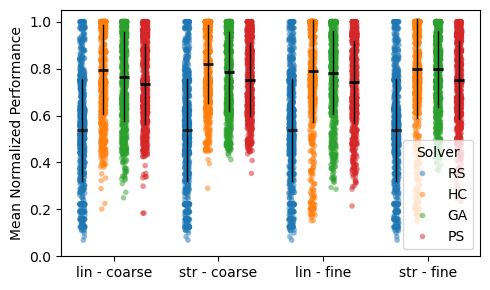

In [71]:
make_dotplot(df_main, 
             x='name_dist', y='norm_fx', hue='solver', hue_order=solver_order, order=name_dist_order, dodge=0.6, legend_title="Solver",
             filename='outputs/name_dist_v_solver_dotplot.pdf')

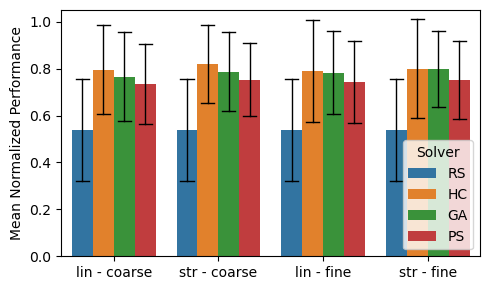

In [72]:
make_barplot(df_main, 
             x='name_dist', y='norm_fx', hue='solver', hue_order=solver_order, order=name_dist_order, dodge=0.6, legend_title="Solver",
             filename='outputs/name_dist_v_solver_barplot.pdf')

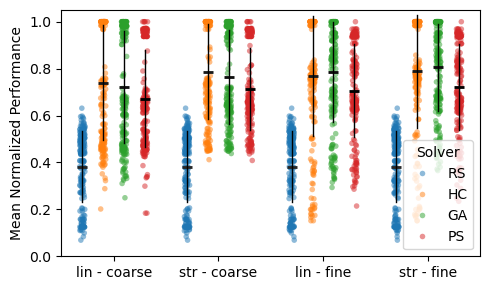

In [73]:
make_dotplot(df_main[df_main['size_cat'] == 'X'], 
             x='name_dist', y='norm_fx', hue='solver', hue_order=solver_order, order=name_dist_order, dodge=0.6, legend_title="Solver",
             filename='outputs/name_dist_v_solver_xlarge_dotplot.pdf')

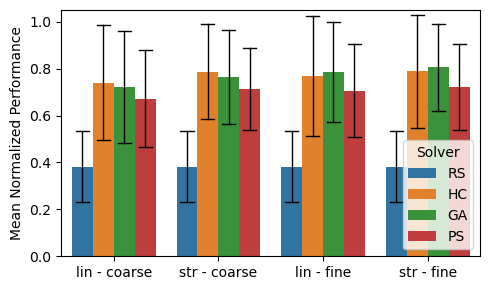

In [74]:
make_barplot(df_main[df_main['size_cat'] == 'X'], 
             x='name_dist', y='norm_fx', hue='solver', hue_order=solver_order, order=name_dist_order, dodge=0.6, legend_title="Solver",
             filename='outputs/name_dist_v_solver_xlarge_barplot.pdf')

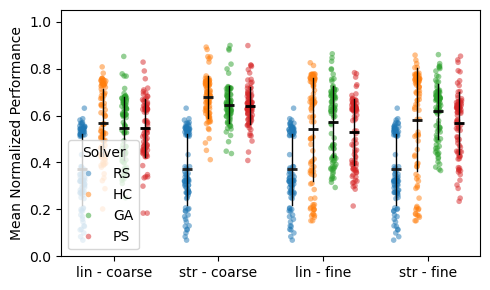

In [75]:
make_dotplot(df_main[(df_main['size_cat'] == 'X') & (df_main['problem'].isin(['BFS', 'GE', 'NN']))],
             x='name_dist', y='norm_fx', hue='solver', hue_order=solver_order, order=name_dist_order, dodge=0.6, loc='lower left', legend_title="Solver",
             filename='outputs/name_dist_v_solver_xlarge_nn_bfs_ge_dotplot.pdf')

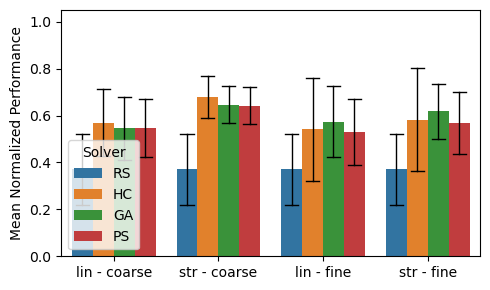

In [76]:
make_barplot(df_main[(df_main['size_cat'] == 'X') & (df_main['problem'].isin(['BFS', 'GE', 'NN']))],
             x='name_dist', y='norm_fx', hue='solver', hue_order=solver_order, order=name_dist_order, dodge=0.6, loc='lower left', legend_title="Solver",
             filename='outputs/name_dist_v_solver_xlarge_nn_bfs_ge_barplot.pdf')

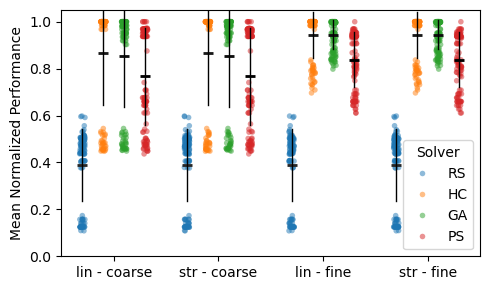

In [77]:
make_dotplot(df_main[(df_main['size_cat'] == 'X') & (df_main['problem'].isin(['OneMax', 'StringM', 'Sphere', 'TSP']))],
             x='name_dist', y='norm_fx', hue='solver', hue_order=solver_order, order=name_dist_order, dodge=0.6, loc='lower right', legend_title="Solver",
             filename='outputs/name_dist_v_solver_xlarge_onemax_stringm_sphere_tsp_dotplot.pdf')

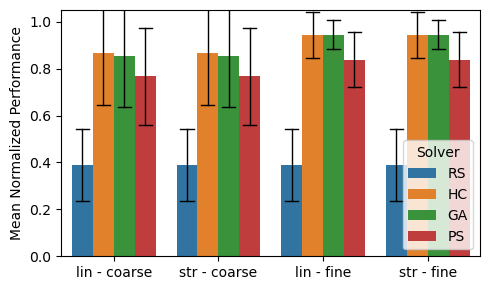

In [78]:
make_barplot(df_main[(df_main['size_cat'] == 'X') & (df_main['problem'].isin(['OneMax', 'StringM', 'Sphere', 'TSP']))],
             x='name_dist', y='norm_fx', hue='solver', hue_order=solver_order, order=name_dist_order, dodge=0.6, loc='lower right', legend_title="Solver",
             filename='outputs/name_dist_v_solver_xlarge_onemax_stringm_sphere_tsp_barplot.pdf')


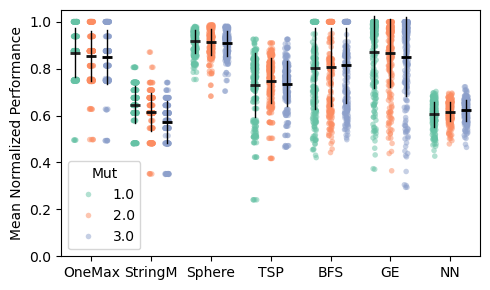

In [79]:
make_dotplot(df_pso,
             x='problem', y='norm_fx', hue='mut', hue_order=(1.0, 2.0, 3.0), order=problem_order, dodge=0.53, legend_title="Mut",
             palette="Set2",
             filename='outputs/problem_v_mut_pso_dotplot.pdf') 

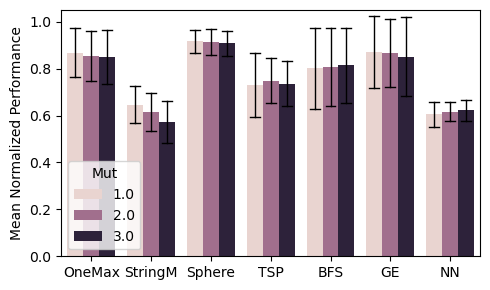

In [80]:
make_barplot(df_pso,
             x='problem', y='norm_fx', hue='mut', hue_order=(1.0, 2.0, 3.0), order=problem_order, dodge=0.6, legend_title="Mut",
             #palette="Set2", # some bug causes an empty plot when I set palette here
             filename='outputs/problem_v_mut_pso_barplot.pdf') 


In [81]:


def run_factorial_anova(df, dv='performance'):
    """
    Runs full factorial ANOVA with all interactions
    df: DataFrame with factors: problem, size_cat, solver, name_type, dist_type
    dv: dependent variable column name
    """
    formula = f"{dv} ~ C(problem) + C(size_cat) + C(solver) + C(name_type) + C(dist_type) + \
        C(problem):C(size_cat) + C(problem):C(solver) + C(problem):C(name_type) + C(problem):C(dist_type) + \
        C(size_cat):C(solver) + C(size_cat):C(name_type) + C(size_cat):C(dist_type) + \
        C(solver):C(name_type) + C(solver):C(dist_type) + \
        C(name_type):C(dist_type)"
    
    model = ols(formula, data=df).fit()
    aov_table = anova_lm(model, typ=2)
    
    # Add effect sizes (partial eta-squared)
    aov_table['pes'] = aov_table['sum_sq'] / (aov_table['sum_sq'] + aov_table['sum_sq'].sum())
    
    return aov_table

In [82]:
results = run_factorial_anova(df_main, dv='norm_fx')
print(results)

                               sum_sq       df            F         PR(>F)  \
C(problem)                 159.751018      6.0  3451.145061   0.000000e+00   
C(size_cat)                 23.710184      3.0  1024.435228   0.000000e+00   
C(solver)                  147.748479      3.0  6383.701843   0.000000e+00   
C(name_type)                 0.477940      1.0    61.950360   3.792479e-15   
C(dist_type)                 0.008799      1.0     1.140577   2.855496e-01   
C(problem):C(size_cat)      76.910078     18.0   553.836503   0.000000e+00   
C(problem):C(solver)        83.587902     18.0   601.924124   0.000000e+00   
C(problem):C(name_type)      1.255692      6.0    27.127052   2.458166e-32   
C(problem):C(dist_type)      7.092053      6.0   153.211572  8.347403e-189   
C(size_cat):C(solver)       27.968175      9.0   402.802775   0.000000e+00   
C(size_cat):C(name_type)     0.208474      3.0     9.007448   5.898584e-06   
C(size_cat):C(dist_type)     0.511328      3.0    22.092715   2.

In [83]:
# for each XL problem, does solver have an effect?
# yes (but this is still not very informative)
for problem in problem_order:
    print(problem)
    dv = 'norm_fx'
    df = df_main[(df_main['size_cat'] == "X") & (df_main['problem'] == problem)]
    formula = f"{dv} ~ C(solver)"
    model = ols(formula, data=df).fit()
    aov_table = anova_lm(model, typ=2)
    
    # Add effect sizes (partial eta-squared)
    aov_table['pes'] = aov_table['sum_sq'] / (aov_table['sum_sq'] + aov_table['sum_sq'].sum())
    print(aov_table)
    

OneMax
              sum_sq     df             F  PR(>F)       pes
C(solver)  27.234751    3.0  18141.427603     0.0  0.497823
Residual    0.238198  476.0           NaN     NaN  0.008596
StringM
              sum_sq     df            F  PR(>F)       pes
C(solver)  55.560481    3.0  45836.98469     0.0  0.499136
Residual    0.192325  476.0          NaN     NaN  0.003438
Sphere
              sum_sq     df             F  PR(>F)       pes
C(solver)  20.059779    3.0  18439.980735     0.0  0.497858
Residual    0.172604  476.0           NaN     NaN  0.008459
TSP
              sum_sq     df          F        PR(>F)       pes
C(solver)   2.694554    3.0  42.268516  3.122845e-24  0.173799
Residual   10.114759  476.0        NaN           NaN  0.441229
BFS
             sum_sq     df          F        PR(>F)       pes
C(solver)  2.075340    3.0  49.520408  7.179186e-28  0.192157
Residual   6.649528  476.0        NaN           NaN  0.432507
GE
              sum_sq     df           F        PR(>F)  

# Figure (a)

In [84]:
# Run Tukey's HSD test
for problem in problem_order:
    print(problem)
    dv = 'norm_fx'
    df = df_main[(df_main['size_cat'] == "X") & (df_main['problem'] == problem)]
    tukey = pairwise_tukeyhsd(
      df[dv],            # dependent variable
      df['solver'],      # factor
      alpha=0.05         # significance level
    )
    print(tukey)

OneMax
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    GA     HC   0.0005 0.9979 -0.0069   0.008  False
    GA     PS  -0.0516    0.0  -0.059 -0.0441   True
    GA     RS  -0.5649    0.0 -0.5724 -0.5575   True
    HC     PS  -0.0521    0.0 -0.0595 -0.0446   True
    HC     RS  -0.5655    0.0 -0.5729  -0.558   True
    PS     RS  -0.5134    0.0 -0.5208 -0.5059   True
----------------------------------------------------
StringM
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    GA     HC   0.0532   0.0  0.0465  0.0599   True
    GA     PS  -0.2768   0.0 -0.2835 -0.2701   True
    GA     RS   -0.805   0.0 -0.8117 -0.7983   True
    HC     PS    -0.33   0.0 -0.3367 -0.3233   True
    HC     RS  -0.8582   0.0 -0.8649 -0.8515   True
    PS     RS  -0.5282   0.0 -0.5349 -0

# Figure (b)

In [88]:
# Run Tukey's HSD test
for size_cat in 'SMLX':
    print(size_cat)
    dv = 'norm_fx'
    df = df_main[(df_main['size_cat'] == size_cat)]
    tukey = pairwise_tukeyhsd(
      df[dv],            # dependent variable
      df['solver'],      # factor
      alpha=0.05         # significance level
    )
    print(tukey)

S
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    GA     HC   0.0318  0.001    0.01  0.0535   True
    GA     PS  -0.0021 0.9948 -0.0238  0.0197  False
    GA     RS  -0.0832    0.0 -0.1049 -0.0614   True
    HC     PS  -0.0338 0.0004 -0.0556 -0.0121   True
    HC     RS  -0.1149    0.0 -0.1367 -0.0932   True
    PS     RS  -0.0811    0.0 -0.1028 -0.0593   True
----------------------------------------------------
M
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    GA     HC   0.0232 0.0184  0.0028  0.0436   True
    GA     PS  -0.0357    0.0 -0.0562 -0.0153   True
    GA     RS  -0.1985    0.0 -0.2189  -0.178   True
    HC     PS  -0.0589    0.0 -0.0794 -0.0385   True
    HC     RS  -0.2217    0.0 -0.2421 -0.2012   True
    PS     RS  -0.1627    0.0 -0.1831 -0.1

# Figure (c) and (d)

In [92]:
# Run Tukey's HSD test
groups = [
    ['OneMax', 'StringM', 'Sphere', 'TSP'],
    ['BFS', 'GE', 'NN']
]
#df_main['problem'].isin(['OneMax', 'StringM', 'Sphere', 'TSP'])
#df_main['problem'].isin(['BFS', 'GE', 'NN'])
for group in groups:
    for solver in solver_order:
        size_cat = 'X'
        print(group, solver, size_cat)
        dv = 'norm_fx'
        df = df_main[(df_main['size_cat'] == size_cat) & df_main['problem'].isin(group) & (df_main['solver'] == solver)]
        formula = f"{dv} ~ C(name_type) + C(dist_type) + C(name_type):C(dist_type)"
        model = ols(formula, data=df).fit()
        aov_table = anova_lm(model, typ=2)

        print(aov_table)

['OneMax', 'StringM', 'Sphere', 'TSP'] RS X
                                 sum_sq     df             F  PR(>F)
C(name_type)               2.366583e-29    1.0  1.014019e-27     1.0
C(dist_type)               1.962896e-29    1.0  8.410502e-28     1.0
C(name_type):C(dist_type)  6.249257e-29    1.0  2.677645e-27     1.0
Residual                   1.110919e+01  476.0           NaN     NaN
['OneMax', 'StringM', 'Sphere', 'TSP'] HC X
                                 sum_sq     df             F    PR(>F)
C(name_type)               1.068660e-28    1.0  3.552037e-27  1.000000
C(dist_type)               6.424299e-01    1.0  2.135324e+01  0.000005
C(name_type):C(dist_type)  3.109838e-28    1.0  1.033655e-26  1.000000
Residual                   1.432086e+01  476.0           NaN       NaN
['OneMax', 'StringM', 'Sphere', 'TSP'] GA X
                                 sum_sq     df             F        PR(>F)
C(name_type)               1.479114e-28    1.0  5.873821e-27  1.000000e+00
C(dist_type)      

In [85]:
# correlation of performance versus size, but this is not really meaningful
for problem in problem_order:
    for solver in solver_order:
        print(problem, solver)
        dv = 'norm_fx'
        df = df_main[(df_main['problem'] == problem) & (df_main['solver'] == solver)]
        print(np.corrcoef(df['norm_fx'], df['size']))


OneMax RS
[[ 1.         -0.77826222]
 [-0.77826222  1.        ]]
OneMax HC
[[1.         0.26146375]
 [0.26146375 1.        ]]
OneMax GA
[[1.         0.49541423]
 [0.49541423 1.        ]]
OneMax PS
[[1.         0.44235757]
 [0.44235757 1.        ]]
StringM RS
[[ 1.         -0.76233993]
 [-0.76233993  1.        ]]
StringM HC
[[1.        0.6398024]
 [0.6398024 1.       ]]
StringM GA
[[1.         0.67395994]
 [0.67395994 1.        ]]
StringM PS
[[1.         0.24989525]
 [0.24989525 1.        ]]
Sphere RS
[[ 1.        -0.8706571]
 [-0.8706571  1.       ]]
Sphere HC
[[1.         0.39365717]
 [0.39365717 1.        ]]
Sphere GA
[[1.         0.59321376]
 [0.59321376 1.        ]]
Sphere PS
[[1.         0.53801434]
 [0.53801434 1.        ]]
TSP RS
[[ 1.         -0.91516696]
 [-0.91516696  1.        ]]
TSP HC
[[ 1.         -0.28236497]
 [-0.28236497  1.        ]]
TSP GA
[[ 1.         -0.22481569]
 [-0.22481569  1.        ]]
TSP PS
[[ 1.         -0.37295028]
 [-0.37295028  1.        ]]
BFS RS
[[ 1.